In [1]:
from tensorflow.keras.datasets import imdb

In [3]:
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10_000)

17473536/17464789 [==============================] - 4s 0us/step


In [11]:
positives = 0
negatives = 0
for label in train_labels:
    if label:
        positives += 1
    else:
        negatives += 1
print(positives, negatives)

12500 12500


In [15]:
max(palabra
    for review in train_data
    for palabra in review)

In [17]:
type(train_data[0][1])

int

In [31]:
# Una review es simplemente un listado indicando el índice de palabras...
# si quisiéramos obtener la review podríamos hacer...
# word_index is a dictionary mapping words to an integer index.
from typing import List
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}
def get_review_string(review_integer: List[int]) -> str:
    review = []
    for valor in review_integer:
        review.append(reverse_word_index.get(valor - 3, "?"))
    return ' '.join(review)

In [33]:
get_review_string(train_data[2])

"? this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had ? working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how ? this is to watch save yourself an hour a bit of your life"

In [34]:
get_review_string(train_data[16968])

"? i came across an ? nightmare while looking for offbeat independent films and glad to say it did not disappoint this crazy half hour ride had me wondering all the way through and the ending was excellent one of those ? moments that really stays with you i've shown it to a number of people and everyone seems to agree hands down the little ? girl was very talented and i think her performance stole the show she ? the heck out of me i can say that much ? did a great job putting this short together all the pieces just fell into place and you can tell that she's a great writer from what she did with this script so well written it's undoubtedly the strongest part of the film the directing was great and the acting was enjoyable but the most important factor here is the strength of the screenplay good job to this girl i can't wait to see more"

Cómo preparar los datos para nuestra red neuronal...  
cada sample es una lista, de longitud variable, con los enteros que indican las palabras utilizadas las listas, lógicamente, son de distinta longitud...  
Tenemos dos opciones:
* hacer padding para que todas las listas tengan igual longitud...y luego convertirlas en un tensor entero de shape (samples, max_length)
* Multi-hot encode... o sea, transformar la review en un vector de 10.000 componentes donde las palabras que aparecen tienen un 1, y las que no aparecen, que serán casi todas, un 0.

La elección elegida es la multi-hot, la verdad es que no me convence... además, no se podría anotar el orden de la review...
 

In [36]:
# Encoding the integer sequences via multi-hot encoding
# esto codifica a la vez todas las reviews!!!
import numpy as np
def vectorize_sequences(reviews: List[int], dimension=10_000) -> np.ndarray:
    results = np.zeros((len(reviews), dimension))
    for i, review in enumerate(reviews):
        for indice_palabra in review:
            results[i, indice_palabra] = 1
    return results


# Hacemos el multi-hot encoding...
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

In [40]:
# Vectorizar las labels es inmediato...
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [48]:
print(x_train.shape, x_test.shape)

(25000, 10000) (25000, 10000)


In [49]:
print(y_train.shape, y_test.shape)

(25000,) (25000,)


El input data son vectores (eso sí, de 10.000 componentes) y la salida es un escalar!!!  
Utilizaremos el siguiente diseño:  
* Dos capas intermedias de 16 neuronas
* 1 capa final de una neurona sola (ya que es un escalar simplemente)

Un modelo que funciona bien en estos casos en una serie de layers de tipo denso, con   
activación relu...

In [42]:
from tensorflow import keras
from tensorflow.keras import layers

In [43]:
model = keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

In [44]:
# Observar que cada capa densa con activación relu simplemente hace...
# output = relu(dot(input, W) + b)   donde W es la matriz de pesos y b el bias...
# o sea, hacemos la transformación lineal input . W + b y luego aplicacmos la activación...
# y esa salida iría para la layer siguiente...
# Además observar que la salida va a ser la sigmoide, o sea, un avalor entre 0 y 1
# que nos va a medir la probabilidad q la review sea clasificada como negativa (0) y positiva(1)

In [45]:
# La matriz W con la que haremos el producto matricial input x W, es por tanto del tipo
# dim_input x neuronas... en este caso son del tipo input (que para la primera capa es 10000) x 16
# Observar que la transformación de cada layer... input x W + b nos transforma del espacio
# inicial (de dim input) a un espacio de dimensión 16 (o 1 para la layer final)

In [46]:
# Utilizaremos como función de pérdida (loss, error) adecuado para cuando la salida es una probabilidad,
# la crossentropy, en este caso la binaria
# como optimizador de la solución el rmsprop
# la mñetrica no tiene impacto en el algoritmo de la red neuronal, pero nos sirve para medir el resultado
# podríamos dar un listado de métricas para evaluar el rendimiento de la red...
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

In [99]:
# Validación del modelo...
# es una práctica estándar usar un set para validar la precisión del modelo durante el entreno
# Lo haremos, apartando 10_000 items del set de entrenamiento para utilizarlos como validación
x_validation = x_train[:10_000]
y_validation = y_train[:10_000]
x_partial_train = x_train[10_000:]
y_partial_train = y_train[10_000:]

In [104]:
len(y_validation)

10000

In [58]:
# Entreno... entrenaremos durante 20 epochs... (recorreremos por tanto
# el set del partial_train 20 veces...
# Haremos un proceso en mini_batches de 512 ítems del set, con lo que para 
# completar cada epoch habrá que utilizar... 15_000 samples de entreno / 512 por mini_batch = 30 ciclos..
# Tras cada epoch se validará la red neuronal con el set que hemos apartado para la validación...
# y con ello nos imprimirá la estadística del accuracy...

In [88]:
history = model.fit(x_partial_train, y_partial_train, 
                    epochs=20, batch_size=512,
                    validation_data=(x_validation, y_validation))

Epoch 1/20
30/30 [==============================] - 2s 63ms/step - loss: 0.6252 - accuracy: 0.8563 - val_loss: 0.4313 - val_accuracy: 0.8602
Epoch 2/20
30/30 [==============================] - 1s 19ms/step - loss: 0.3130 - accuracy: 0.8903 - val_loss: 0.3627 - val_accuracy: 0.8629
Epoch 3/20
30/30 [==============================] - 1s 19ms/step - loss: 0.2395 - accuracy: 0.9098 - val_loss: 0.3253 - val_accuracy: 0.8709
Epoch 4/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1989 - accuracy: 0.9255 - val_loss: 0.3253 - val_accuracy: 0.8748
Epoch 5/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1615 - accuracy: 0.9415 - val_loss: 0.3452 - val_accuracy: 0.8732
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1342 - accuracy: 0.9513 - val_loss: 0.3598 - val_accuracy: 0.8741
Epoch 7/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1084 - accuracy: 0.9615 - val_loss: 0.3857 - val_accuracy: 0.8714
Epoch 8/20
30

In [61]:
history_dictionary = history.history
print(history_dictionary.keys())
history_dictionary
# Nos muestra el histórico de cada epoch para estos 4 aspectos...
# observar que loss y accuray son la media en el epoch... mientras que val_... es el que da la red
# luego del epoch con los datos de validación...

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


{'loss': [0.5185487270355225,
  0.3140522837638855,
  0.22932863235473633,
  0.18351998925209045,
  0.14577403664588928,
  0.11993783712387085,
  0.10053785145282745,
  0.08306679874658585,
  0.06990418583154678,
  0.05713823065161705,
  0.04737775772809982,
  0.04028349369764328,
  0.030679654330015182,
  0.024828124791383743,
  0.020399965345859528,
  0.01674751751124859,
  0.012172159738838673,
  0.009785549715161324,
  0.006619365885853767,
  0.007021078374236822],
 'accuracy': [0.7910666465759277,
  0.9016000032424927,
  0.9266666769981384,
  0.9403333067893982,
  0.9549999833106995,
  0.9657333493232727,
  0.9710000157356262,
  0.9769333600997925,
  0.9810666441917419,
  0.9862666726112366,
  0.9890666604042053,
  0.9908000230789185,
  0.9937333464622498,
  0.9954000115394592,
  0.9964666962623596,
  0.9972666501998901,
  0.9984666705131531,
  0.9989333152770996,
  0.9994666576385498,
  0.9990666508674622],
 'val_loss': [0.39080068469047546,
  0.3237793743610382,
  0.279308676719

In [62]:
# ??? el training_loss va para abajo pero el del validation_loss aumenta??

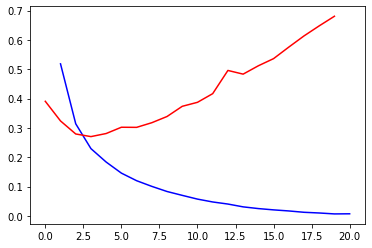

In [73]:
import matplotlib.pyplot as plt
plt.plot(range(1, 21), history_dictionary['loss'], 'blue', history_dictionary['val_loss'], 'red')

In [74]:
# Observamos que la pérdida tras cada epoch va disminuyendo..
# mientras que la pérdida evaluada en el set de validación aumenta!!!

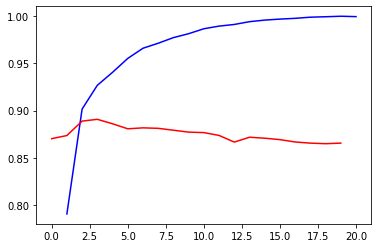

In [75]:
# Veamos ahora el accuracy... tanto del training tras cada epoch... como después
# de cada epoch con el set de validación...
plt.plot(range(1, 21), history_dictionary['accuracy'], 'blue', history_dictionary['val_accuracy'], 'red')

In [76]:
# pasa algo similar... el accuracy en el set de entrenamiento se vuelve casi del 100 %
# mientras que la del set de validación es del 87 %

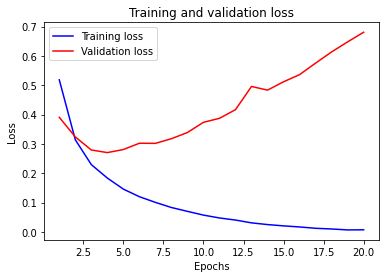

In [81]:
# Otra forma más fina...
epochs = range(1, 21) 
plt.plot(epochs, history.history['loss'], "blue", label="Training loss")
plt.plot(epochs, history.history['val_loss'],'red', label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

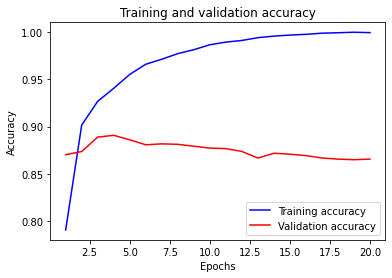

In [82]:
# Ahora con el accuracy
epochs = range(1, 21) 
plt.plot(epochs, history.history['accuracy'], "blue", label="Training accuracy")
plt.plot(epochs, history.history['val_accuracy'],'red', label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
# Observar que el pico tanto del accuracy como de la pérdida para el set de validación ocurre tras el cuarto epoch
# This is an example of what we warned against earlier: 
# a model that performs better on the training data isn’t necessarily a model that will
# do better on data it has never seen before.
# In precise terms, what you’re seeing is overfitting: after the fourth epoch, you’re overoptimizing on the training data, and you
# end up learning representations that are specific to the training data and don’t generalize to data outside of the training set.
# In this case, to prevent overfitting, you could stop training after four epochs.
# In general, you can use a range of techniques to mitigate overfitting, which we’ll cover in chapter 5

In [84]:
# O sea, para evitar el sobreentrenamiento, entranaremos otra vez, pero sólo durante 4 epochs...
# y leugo evaluaremos en los datos de test...

In [89]:
# Todo desde 0, ya sabiendo que tenemos que pararnos en 4 epochs...
model = keras.Sequential([
    layers.Dense(16, activation="relu"),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid"),
])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
# Ahora ya no nos interesa el historial, ni utilizar la validación,
# también, en el entreno utilziaremos todo el set del train.. (no como antes que reservábamos algunos para validar el modelo)
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Epoch 1/4
49/49 [==============================] - 1s 14ms/step - loss: 0.4654 - accuracy: 0.8178
Epoch 2/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2665 - accuracy: 0.9107
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2028 - accuracy: 0.9286
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2915 - accuracy: 0.8852


In [95]:
results

[0.2815724313259125, 0.8863999843597412]

In [96]:
# Using a trained model to generate predictions on new data
model.predict(x_test[10:25])

array([[0.86916596],
       [0.03901845],
       [0.02978572],
       [0.04250407],
       [0.9784135 ],
       [0.02911198],
       [0.91154695],
       [0.57610935],
       [0.04085487],
       [0.07627279],
       [0.9741254 ],
       [0.974913  ],
       [0.25206113],
       [0.911839  ],
       [0.8637403 ]], dtype=float32)

In [97]:
# Observa que para algunos nos da poca seguridad, como uno que pone 0.25 en este caso
# Otro pone 0.57 !!! ufff

# Further experiments
The following experiments will help convince you that the architecture choices you’ve made are all fairly reasonable, although there’s still room for improvement:
* You used two representation layers before the final classification layer. Try using one or three representation layers, and see how doing so affects validation and test accuracy.
* Try using layers with more units or fewer units: 32 units, 64 units, and so on.
* Try using the mse loss function instead of binary_crossentropy.
* Try using the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

In [107]:
# experimento 1, tres layers...
model = keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_partial_train, y_partial_train,
                    epochs=20, batch_size=512,
                    validation_data=(x_validation, y_validation))

Epoch 1/20
30/30 [==============================] - 2s 32ms/step - loss: 0.5721 - accuracy: 0.7425 - val_loss: 0.4461 - val_accuracy: 0.8585
Epoch 2/20
30/30 [==============================] - 1s 18ms/step - loss: 0.3439 - accuracy: 0.8955 - val_loss: 0.3603 - val_accuracy: 0.8581
Epoch 3/20
30/30 [==============================] - 1s 17ms/step - loss: 0.2288 - accuracy: 0.9289 - val_loss: 0.3335 - val_accuracy: 0.8671
Epoch 4/20
30/30 [==============================] - 1s 17ms/step - loss: 0.1730 - accuracy: 0.9439 - val_loss: 0.3037 - val_accuracy: 0.8776
Epoch 5/20
30/30 [==============================] - 1s 18ms/step - loss: 0.1370 - accuracy: 0.9575 - val_loss: 0.3259 - val_accuracy: 0.8744
Epoch 6/20
30/30 [==============================] - 1s 19ms/step - loss: 0.1133 - accuracy: 0.9658 - val_loss: 0.3474 - val_accuracy: 0.8768
Epoch 7/20
30/30 [==============================] - 1s 17ms/step - loss: 0.0900 - accuracy: 0.9737 - val_loss: 0.3491 - val_accuracy: 0.8747
Epoch 8/20
30

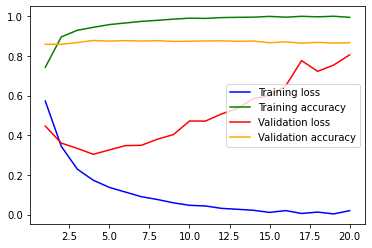

In [119]:
plt.plot(range(1, 21), history.history['loss'], color='b', label="Training loss")
plt.plot(range(1, 21), history.history['accuracy'], 'green', label="Training accuracy")
plt.plot(range(1, 21), history.history['val_loss'], label="Validation loss", color='r')
plt.plot(range(1, 21), history.history['val_accuracy'], color='orange',label="Validation accuracy")  
plt.legend()

In [120]:
# Ufff, lo mismo que antes... tras 4 epochs se observa overfitting... ahora lo hago parando a los 4...

In [121]:
model = keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)
print(results)

Epoch 1/4
49/49 [==============================] - 1s 13ms/step - loss: 0.4521 - accuracy: 0.8134
Epoch 2/4
49/49 [==============================] - 1s 12ms/step - loss: 0.2501 - accuracy: 0.9091
Epoch 3/4
49/49 [==============================] - 1s 12ms/step - loss: 0.1946 - accuracy: 0.9280
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.3335 - accuracy: 0.8718
[0.33353015780448914, 0.8718000054359436]


In [122]:
# Similar a lo de antes!!!

In [123]:
# Ultima prueba... vectorizando de otra forma los valores...
def vectorize_sequences(reviews: List[int], dimension=10_000) -> np.ndarray:
    results = np.zeros((len(reviews), dimension))
    for i, review in enumerate(reviews):
        for indice_palabra in review:
            results[i, indice_palabra] = 1
    return results

def vectorize_sequences_2(reviews: List[int], dimension=10_000) -> np.ndarray:
    results = np.zeros((len(reviews), dimension))
    for i, review in enumerate(reviews):
        for indice_palabra in review:
            results[i, indice_palabra] += 1
    return results

In [126]:
# Hacemos el multi-hot-variado... encoding...
x_train = vectorize_sequences_2(train_data)
x_test = vectorize_sequences_2(test_data)
# Vectorizar las labels es inmediato...
y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")
x_validation = x_train[:10_000]
y_validation = y_train[:10_000]
x_partial_train = x_train[10_000:]
y_partial_train = y_train[10_000:]

In [127]:
model = keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(x_partial_train, y_partial_train, 
                    epochs=20, batch_size=512,
                    validation_data=(x_validation, y_validation))

Epoch 1/20
30/30 [==============================] - 2s 34ms/step - loss: 0.5495 - accuracy: 0.7337 - val_loss: 0.4199 - val_accuracy: 0.8536
Epoch 2/20
30/30 [==============================] - 1s 20ms/step - loss: 0.3489 - accuracy: 0.8865 - val_loss: 0.3272 - val_accuracy: 0.8876
Epoch 3/20
30/30 [==============================] - 1s 20ms/step - loss: 0.2685 - accuracy: 0.9123 - val_loss: 0.3302 - val_accuracy: 0.8771
Epoch 4/20
30/30 [==============================] - 1s 27ms/step - loss: 0.2147 - accuracy: 0.9313 - val_loss: 0.2808 - val_accuracy: 0.8944
Epoch 5/20
30/30 [==============================] - 1s 26ms/step - loss: 0.1829 - accuracy: 0.9415 - val_loss: 0.2876 - val_accuracy: 0.8900
Epoch 6/20
30/30 [==============================] - 1s 22ms/step - loss: 0.1537 - accuracy: 0.9521 - val_loss: 0.2909 - val_accuracy: 0.8890
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 0.1356 - accuracy: 0.9569 - val_loss: 0.2892 - val_accuracy: 0.8929
Epoch 8/20
30

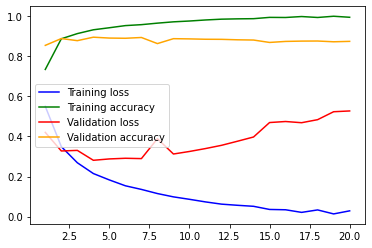

In [128]:
plt.plot(range(1, 21), history.history['loss'], color='b', label="Training loss")
plt.plot(range(1, 21), history.history['accuracy'], 'green', label="Training accuracy")
plt.plot(range(1, 21), history.history['val_loss'], label="Validation loss", color='r')
plt.plot(range(1, 21), history.history['val_accuracy'], color='orange',label="Validation accuracy")  
plt.legend()

In [129]:
# Parece que hay overfitting tras 3l cuarto epoch...
# de todas formas parece mejor que el resultado anterior... simplemente cambiando
# la forma de codificar los datos!!

In [130]:
# Test final...
model = keras.Sequential([
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=16, activation="relu"),
    layers.Dense(units=1, activation="sigmoid"),
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)


Epoch 1/4
49/49 [==============================] - 1s 13ms/step - loss: 0.5037 - accuracy: 0.7846
Epoch 2/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2976 - accuracy: 0.8928
Epoch 3/4
49/49 [==============================] - 1s 13ms/step - loss: 0.2350 - accuracy: 0.9153
Epoch 4/4
782/782 [==============================] - 2s 2ms/step - loss: 0.2908 - accuracy: 0.8874


In [131]:
results

[0.29078084230422974, 0.8873599767684937]

In [ ]:
# Puyes no, parece similar!!